In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import joblib
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder

In [3]:
df = pd.read_csv("March_2024_AF2_01.txt", sep=r"\s+", header=None)
df.columns = ['Protein_number', 'res_number', 'PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2', 'expected_frequency', 'plDDT', 'RSA1', 'RSA2']
df

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,95,n,l,E,Q,T,T,0.736402,96.220001,89.762611,98.582039
2,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
3,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
4,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
...,...,...,...,...,...,...,...,...,...,...,...,...
671150,23508,14909273,j,d,G,L,C,C,0.623739,95.459999,1.531394,20.793951
671151,23508,14909291,f,d,C,D,P,S,0.047665,95.379997,11.473963,100.000000
671152,23508,14909390,j,d,G,P,S,P,0.623739,80.699997,65.849922,88.452087
671153,23508,14909434,g,f,L,T,C,C,0.430306,79.760002,60.491493,46.452702


In [4]:
numerical_cols = ['expected_frequency', 'plDDT', 'RSA1', 'RSA2']
categorical_cols = ['PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2']

In [5]:
# removing the columns that will not be included in the clustering
df = df.drop('Protein_number', axis=1)
df = df.drop('res_number', axis=1)
df

,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,n,l,E,Q,T,T,0.736402,96.220001,89.762611,98.582039
2,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
3,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
4,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
...,...,...,...,...,...,...,...,...,...,...
671150,j,d,G,L,C,C,0.623739,95.459999,1.531394,20.793951
671151,f,d,C,D,P,S,0.047665,95.379997,11.473963,100.000000
671152,j,d,G,P,S,P,0.623739,80.699997,65.849922,88.452087
671153,g,f,L,T,C,C,0.430306,79.760002,60.491493,46.452702


## Visualization using UMAP

In [6]:
df_umap = df.copy() # creating a copy for visualization purposes

In [7]:
# Numerical data is transformed using Yeo-Johnson transformation
# to stabilize variance and make data more closely resemble a normal distribution

pt = PowerTransformer(method='yeo-johnson')
df_umap[numerical_cols] = pt.fit_transform(df_umap[numerical_cols])

# Categorical data is transformed using Label Encoding
for cat_col in categorical_cols:
    le = LabelEncoder()
    df_umap[cat_col] = le.fit_transform(df_umap[cat_col])

# sample data and combining transformed categorical and numerical columns
df_umap_sample = df_umap.sample(frac=0.1, random_state=42)
df_umap = df_umap_sample[numerical_cols + categorical_cols].to_numpy()

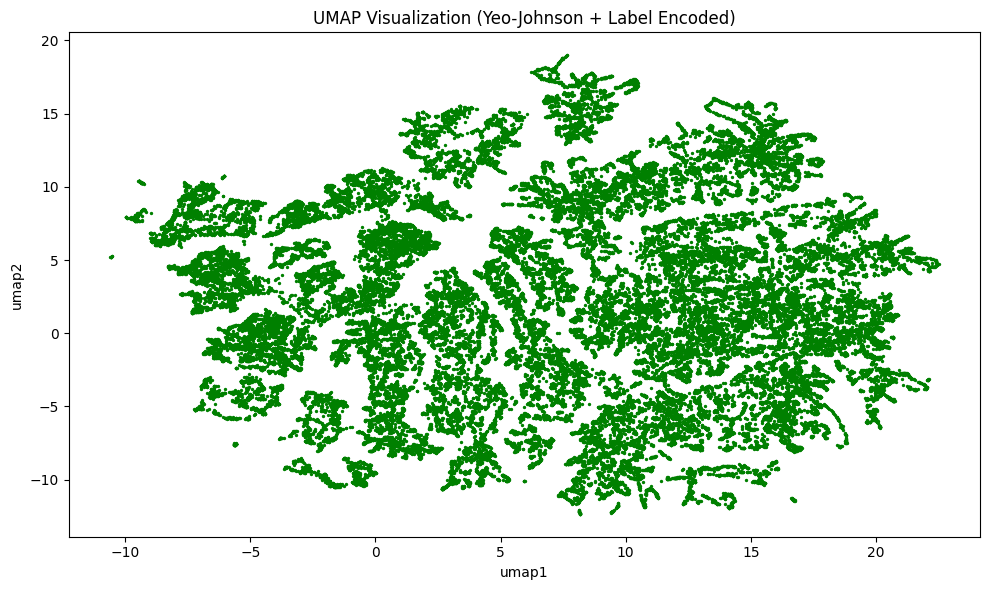

In [8]:
umap = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.3)
embedding = umap.fit_transform(df_umap)

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, alpha=1.0, c='green')
plt.title('UMAP Visualization (Yeo-Johnson + Label Encoded)')
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.tight_layout()
plt.show()

#### The UMAP 2D visualization reveals almost random structure, with couple of noticeable local groupings of data points.  
#### This suggests that the dataset can contain underlying patterns that may be captured through clustering in the full feature space, even though the visualization was generated from sampled data.

## K-Prototypes clustering

In [9]:
# for k-prototypes categorical data doesn’t need any pre-processing, we only need array with indices of categorical columns
kprot_df = df.copy()

scaler = StandardScaler()
kprot_df[numerical_cols] = scaler.fit_transform(kprot_df[numerical_cols])

categorical_cols_indices = [kprot_df.columns.get_loc(col) for col in categorical_cols]
print(categorical_cols_indices)
kprot_df

[0, 1, 2, 3, 4, 5]


,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,j,j,G,G,C,S,1.691557,0.789870,0.519842,0.526168
1,n,l,E,Q,T,T,1.150260,2.544408,0.121948,0.474194
2,i,d,G,N,S,C,-1.471687,-0.588347,0.519842,0.526168
3,d,i,T,V,C,C,-1.542575,0.160885,0.519842,0.526168
4,i,d,V,P,C,C,-1.471687,-0.280183,0.519842,0.283008
...,...,...,...,...,...,...,...,...,...,...
671150,j,d,G,L,C,C,0.725737,2.507408,-3.307310,-2.377064
671151,f,d,C,D,P,S,-1.444954,2.503514,-2.920875,0.526168
671152,j,d,G,P,S,P,0.725737,1.788846,-0.807460,0.102889
671153,g,f,L,T,C,C,-0.003132,1.743085,-1.015724,-1.436564


In [11]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=8, init='Cao')
clusters = kproto.fit_predict(kprot_df.to_numpy(), categorical=categorical_cols_indices)
joblib.dump(kproto, 'results/kprototypes_model_k8.joblib')

['results/kprototypes_model_k8.joblib']

In [12]:
print(kproto.cost_)

1394325.3726086502


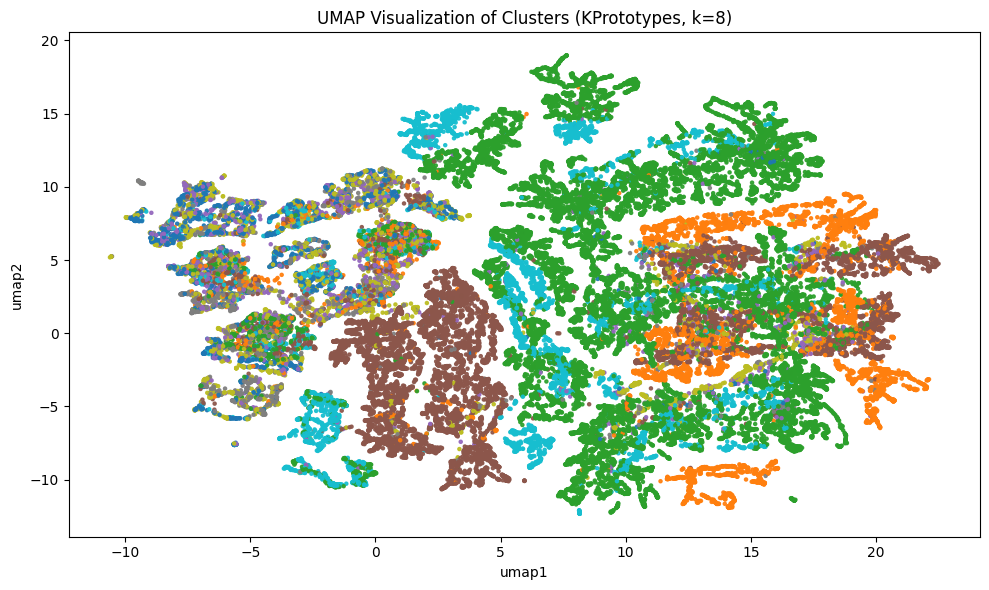

In [13]:
# Visualization of the clustering on sampled data
sample_indices = df_umap_sample.index
clusters_sample = np.array(clusters)[sample_indices]

plt.figure(figsize=(10, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=clusters_sample,
    cmap='tab10',
    s=5,
    alpha=0.9
)
plt.title('UMAP Visualization of Clusters (KPrototypes, k=8)')
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.tight_layout()
plt.show()

In [15]:
import gower
from sklearn.metrics import silhouette_score

X = kprot_df.sample(frac=0.04, random_state=42)
gower_dist = gower.gower_matrix(X.to_numpy())

sample_indices = X.index
clusters_sample = np.array(clusters)[sample_indices]
sil_score = silhouette_score(gower_dist, clusters_sample, metric='precomputed')

print(f"Silhouette score (Gower + KPrototypes): {sil_score:.4f}")

Silhouette score (Gower + KPrototypes): 0.1933


#### The silhouette score suggest weak but present clustering structure, indicating partial separation between clusters. It is slightly better than with 6 clusters.